##Evaluating a Ranking Model

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, CustomFilter, CustomFactor
from quantopian.pipeline.data import Fundamentals 
from quantopian.pipeline.data import factset
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.classifiers.morningstar import Sector 
from quantopian.pipeline.filters import QTradableStocksUS, Q1500US, Q500US
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as st
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Latest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from zipline.utils.numpy_utils import ( repeat_first_axis, repeat_last_axis )

In [2]:
from quantopian.pipeline.factors import ( CustomFactor, BusinessDaysSincePreviousEvent, 
                                         BusinessDaysUntilNextEvent, SimpleMovingAverage, 
                                         AverageDollarVolume, Returns, RSI, 
                                         RollingLinearRegressionOfReturns, RollingSpearmanOfReturns, 
                                         AnnualizedVolatility, Returns, DailyReturns)

In [3]:
import talib
import pandas as pd
import numpy as np
from time import time

In [4]:
import alphalens as al
import pyfolio as pf
from scipy import stats
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [5]:
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from sklearn.metrics import classification_report

In [6]:
WIN_LIMIT = 0.0

In [7]:
def preprocess(a):
    
    a = np.nan_to_num(a - np.nanmean(a))
    
    a = winsorize(a, limits=[WIN_LIMIT,WIN_LIMIT])

    return preprocessing.scale(a)

In [62]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [9]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios

In [10]:
has_data = (bs.working_capital.latest.notnull()
            & bs.total_assets.latest.notnull()
            & or_.roic.latest.notnull()
            & morningstar.cash_flow_statement.operating_cash_flow.latest.notnull()
            & EarningsSurprises.eps_act.latest.notnull()
            & is_.ebit.latest.notnull()
            & is_.ebitda.latest.notnull()
            & cfs.capital_expenditure.latest.notnull()
            & cfs.free_cash_flow.latest.notnull()
            & bs.common_stock_equity.latest.notnull()
)

In [11]:
has_data_st = (bs.working_capital.latest.notnull()
            & bs.total_assets.latest.notnull()
            & or_.roic.latest.notnull()
            & morningstar.cash_flow_statement.operating_cash_flow.latest.notnull()
            & EarningsSurprises.eps_act.latest.notnull()
            & is_.ebit.latest.notnull()
            & is_.ebitda.latest.notnull()
            & cfs.capital_expenditure.latest.notnull()
            & cfs.free_cash_flow.latest.notnull()
            & bs.common_stock_equity.latest.notnull()
            & st.total_scanned_messages.latest.notnull()

)

In [12]:
is_tradeable = (QTradableStocksUS()
                & has_data )

In [13]:
is_tradeable0 = (QTradableStocksUS()
                & has_data_st )

In [14]:
universe = is_tradeable

##Factor Combination

In [15]:
def make_factors():
    
        class MessageSum(CustomFactor):
            inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, stocktwits.bull_scored_messages, stocktwits.bear_scored_messages, stocktwits.total_scanned_messages]
            window_length = 5
            def compute(self, today, assets, out, high, low, close, bull, bear, total):
                v = np.nansum((high-low)/close, axis=0)
                out[:] = preprocess(v*np.nansum(total*(bear-bull), axis=0))
                
        class fcf(CustomFactor):
            inputs = [Fundamentals.fcf_yield]
            window_length = 1
            def compute(self, today, assets, out, fcf_yield):
                out[:] = preprocess(np.nan_to_num(fcf_yield[-1,:]))
                
        class Direction(CustomFactor):
            inputs = [USEquityPricing.open, USEquityPricing.close]
            window_length = 21
            def compute(self, today, assets, out, open, close):
                p = (close-open)/close
                out[:] = preprocess(np.nansum(-p,axis=0))
                
        class mean_rev(CustomFactor):   
            inputs = [USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
            window_length = 30
            def compute(self, today, assets, out, high, low, close):
            
                p = (high+low+close)/3

                m = len(close[0,:])
                n = len(close[:,0])
                
                b = np.zeros(m)
                a = np.zeros(m)
                
                for k in range(10,n+1):
                    price_rel = np.nanmean(p[-k:,:],axis=0)/p[-1,:]
                    wt = np.nansum(price_rel)
                    b += wt*price_rel
                    price_rel = 1.0/price_rel
                    wt = np.nansum(price_rel)
                    a += wt*price_rel
                
                out[:] = preprocess(b-a)
                
        class volatility(CustomFactor):
            inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume]
            window_length = 5
            def compute(self, today, assets, out, high, low, close, volume):
                vol = np.nansum(volume,axis=0)*np.nansum(np.absolute((high-low)/close),axis=0)
                out[:] = preprocess(-vol)
                
        class growthscore(CustomFactor):
            inputs = [Fundamentals.growth_score]
            window_length = 1
            def compute(self, today, assets, out, growth_score):
                out[:] = preprocess(growth_score[-1,:])
                
        class peg_ratio(CustomFactor):
            inputs = [Fundamentals.peg_ratio]
            window_length = 1
            def compute(self, today, assets, out, peg_ratio):
                out[:] = preprocess(-1.0/peg_ratio[-1,:])
                
        class MoneyflowVolume5d(CustomFactor):
            inputs = (USEquityPricing.close, USEquityPricing.volume)
            window_length = 6
            
            def compute(self, today, assets, out, close_extra, volume_extra):
                # slice off the extra row used to get the direction of the close
                # on the first day
                close = close_extra[1:]
                volume = volume_extra[1:]
                
                dollar_volume = close * volume
                denominator = dollar_volume.sum(axis=0)
                
                difference = np.diff(close_extra, axis=0)
                direction = np.where(difference > 0, 1, -1)
                numerator = (direction * dollar_volume).sum(axis=0)
                
                out[:] = preprocess(-np.divide(numerator, denominator))
                
        class Trendline(CustomFactor):
            inputs = [USEquityPricing.close]
            window_length = 252
            
            _x = np.arange(window_length)
            _x_var = np.var(_x)

            def compute(self, today, assets, out, close):
            
                x_matrix = repeat_last_axis(
                (self.window_length - 1) / 2 - self._x,
                len(assets),
                )

                y_bar = np.nanmean(close, axis=0)
                y_bars = repeat_first_axis(y_bar, self.window_length)
                y_matrix = close - y_bars

                out[:] = preprocess(-np.divide(
                (x_matrix * y_matrix).sum(axis=0) / self._x_var,
                self.window_length
                ))
                
        class Revenue(CustomFactor):
            inputs = [Fundamentals.total_revenue]
            window_length = 252
            def compute(self, today, assets, out, revenue):
                out[:] = preprocess((revenue[-1] > revenue[0]).astype(int))

        class GrossMarginChange(CustomFactor):
            window_length = 126
            inputs = [Fundamentals.gross_margin]
            def compute(self, today, assets, out, gross_margin):
                out[:] = preprocess((gross_margin[-1] > gross_margin[0]).astype(int))

        class Gross_Income_Margin(CustomFactor):
            inputs = [Fundamentals.cost_of_revenue, Fundamentals.total_revenue]
            window_length = 1
            def compute(self, today, assets, out, cost_of_revenue, sales):
                gross_income_margin = sales[-1]/sales[-1] - cost_of_revenue[-1]/sales[-1]
                out[:] = preprocess(gross_income_margin)

        class MaxGap(CustomFactor): 
            # the biggest absolute overnight gap in the previous 90 sessions
            inputs = [USEquityPricing.close] ; window_length = 90
            def compute(self, today, assets, out, close):
                abs_log_rets = np.abs(np.diff(np.log(close),axis=0))
                max_gap = np.max(abs_log_rets, axis=0)
                out[:] = preprocess(max_gap)
        
        class CapEx_Vol(CustomFactor):
            inputs=[
                Fundamentals.cap_ex_reported,
                Fundamentals.total_assets]
            window_length = 390
            def compute(self, today, assets, out, capex, total_assets):
                v = capex/total_assets
                v[np.isinf(v)] = np.nan
                 
                out[:] = preprocess(-np.ptp(v,axis=0))
                
        class fcf_ev(CustomFactor):
            inputs=[
                Fundamentals.fcf_per_share,
                Fundamentals.shares_outstanding,
                Fundamentals.enterprise_value,]
            window_length = 1
            def compute(self, today, assets, out, fcf, shares, ev):
                v = fcf*shares/ev
                v[np.isinf(v)] = np.nan
                 
                out[:] = preprocess(v[-1])
                
        class DebtToTotalAssets(CustomFactor):
            inputs = [Fundamentals.long_term_debt,
              Fundamentals.current_debt,
              Fundamentals.cash_and_cash_equivalents,
              Fundamentals.total_assets]
            window_length = 1
            
            def compute(self, today, assets, out, ltd, std, cce, ta):
                std_part = np.maximum(std - cce, np.zeros(std.shape))
                v = np.divide(ltd + std_part, ta)
                v[np.isinf(v)] = np.nan
                out[:] = preprocess(np.ravel(v))
                                                                                             
        return {
            'MessageSum':              MessageSum,
            'FCF':                     fcf,
            'Direction':               Direction,
            'mean_rev':                mean_rev,
            'volatility':              volatility,
            'GrowthScore':             growthscore,
            'PegRatio':                peg_ratio,
            'MoneyFlow':               MoneyflowVolume5d,
            'Trendline':               Trendline,
            'Revenue':                 Revenue,
            'GrossMarginChange':       GrossMarginChange,
            'Gross_Income_Margin':     Gross_Income_Margin,
            'MaxGap':                  MaxGap,
            'CapEx_Vol':               CapEx_Vol,
            'fcf_ev':                  fcf_ev,
            'DebtToTotalAssets':       DebtToTotalAssets,
        }


In [16]:
factors = make_factors()

combined_alpha = None

for name, f in factors.iteritems():
        if combined_alpha == None:
            combined_alpha = f(mask=universe)
        else:
            combined_alpha = combined_alpha+f(mask=universe)

##Individual Factors

In [17]:
class atr_10days_percent(CustomFactor):  
    inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]  
    window_length = 11  
    def compute(self, today, assets, out, high, low, close):  
        range_low = np.maximum(high[1:], close[:-1]) 
        range_high = np.minimum(low[1:], close[:-1])  
        out[:] = np.mean(((range_high - range_low)/close[:-1])*100, axis=0) 

In [18]:
    class AcquirersMultiple_1period(CustomFactor):    
        inputs = [Fundamentals.enterprise_value,
                  Fundamentals.ebitda,
                  Fundamentals.capital_expenditure]
    
        def compute(self, today, assets, out, enterprise_value, ebitda, capital_expenditure):
            out[:] = enterprise_value/(ebitda+capital_expenditure)

In [19]:
class Piotroski(CustomFactor):
        inputs = [
                Fundamentals.roa,
                Fundamentals.operating_cash_flow,
                Fundamentals.cash_flow_from_continuing_operating_activities,
                Fundamentals.long_term_debt_equity_ratio,
                Fundamentals.current_ratio,
                Fundamentals.shares_outstanding,
                Fundamentals.gross_margin,
                Fundamentals.assets_turnover,
                ]
 
        window_length = 100
        window_safe = True
    
        def compute(self, today, assets, out,roa, cash_flow, cash_flow_from_ops, long_term_debt_ratio, current_ratio, shares_outstanding, gross_margin, assets_turnover):
            
            profit = (
                        (roa[-1] > 0).astype(int) +
                        (cash_flow[-1] > 0).astype(int) +
                        (roa[-1] > roa[0]).astype(int) +
                        (cash_flow_from_ops[-1] > roa[-1]).astype(int)
                    )
        
            leverage = (
                        (long_term_debt_ratio[-1] < long_term_debt_ratio[0]).astype(int) +
                        (current_ratio[-1] > current_ratio[0]).astype(int) + 
                        (shares_outstanding[-1] <= shares_outstanding[0]).astype(int)
                        )
        
            operating = (
                        (gross_margin[-1] > gross_margin[0]).astype(int) +
                        (assets_turnover[-1] > assets_turnover[0]).astype(int)
                        )
        
            out[:] = preprocess(profit + leverage + operating)
            

In [20]:
def InfoRatio():
        n = 252
        mu = Returns(window_length=n)
        sigma = AnnualizedVolatility(window_length=n)
        return mu / sigma

In [21]:
def SMA_return():
        # Short close price average.
        ShortAvg = SimpleMovingAverage(
            inputs=[USEquityPricing.close],
            window_length=5,
        )

        # Long close price average.
        LongAvg = SimpleMovingAverage(
            inputs=[USEquityPricing.close],
            window_length=63,
        )

        return (ShortAvg - LongAvg) / LongAvg

In [22]:
class GP_to_A(CustomFactor):
    
    inputs = [morningstar.income_statement.gross_profit, morningstar.balance_sheet.total_assets]
    window_length = 1
    
    def compute(self, today, assets, out, gross_profit, total_assets):       
        out[:] = gross_profit[-1] / total_assets[-1]
                

In [73]:
pipe = Pipeline(
    columns = {
            'GP_to_A' : GP_to_A(),
            'Piotroski' : Piotroski(mask=universe),
            'InfoRatio' : InfoRatio(),
            'SMA_return' : SMA_return(),
            'atr_10d_pct' : atr_10days_percent(mask=universe),
            'Returns' : DailyReturns(inputs=[USEquityPricing.close],mask=universe),
            'AM' : AcquirersMultiple_1period(window_length=1, mask=universe),
            'Sector' : Sector()
    },
    screen=universe
)

start_timer = time()
results = run_pipeline(pipe, '2014-01-01', '2018-01-01')
end_timer = time()
results.fillna(value=0);

print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 99.67 secs


In [74]:
results.head()

AM   GP_to_A  InfoRatio  \
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])   49.159087  0.067010   0.173793   
                          Equity(31 [ABAX])  131.145958  0.104819   0.154653   
                          Equity(39 [DDC])   444.764352  0.007827   0.097192   
                          Equity(52 [ABM])    44.236191  0.063798   2.334683   
                          Equity(53 [ABMD])  637.563791  0.195107   2.448400   

                                             Piotroski   Returns  SMA_return  \
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])   1.047974  0.012011    0.062442   
                          Equity(31 [ABAX])   1.605952 -0.002990    0.069691   
                          Equity(39 [DDC])    0.489997  0.015570    0.055055   
                          Equity(52 [ABM])    0.489997 -0.007636    0.037099   
                          Equity(53 [ABMD])  -0.067980 -0.027303    0.090974   

                                             Sector  atr_10d_pct  
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])     311    -1.627799  
                          Equity(31 [ABAX])     206    -2.542531  
                          Equity(39 [DDC])      101    -1.854898  
                          Equity(52 [ABM])      310    -1.671402  
                          Equity(53 [ABMD])     206    -3.492951

In [75]:
results['atr_10d_pct_z']=results.groupby('Sector')['atr_10d_pct'].transform(lambda x: (x-x.mean())/x.std())
results['atr_10d_pct_m']=results.groupby('Sector')['atr_10d_pct'].transform(lambda x: x.mean())
results['atr_10d_pct_win']=scipy.stats.mstats.winsorize(results['atr_10d_pct'],inplace=True,limits=.001)
results.head()

AM   GP_to_A  InfoRatio  \
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])   49.159087  0.067010   0.173793   
                          Equity(31 [ABAX])  131.145958  0.104819   0.154653   
                          Equity(39 [DDC])   444.764352  0.007827   0.097192   
                          Equity(52 [ABM])    44.236191  0.063798   2.334683   
                          Equity(53 [ABMD])  637.563791  0.195107   2.448400   

                                             Piotroski   Returns  SMA_return  \
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])   1.047974  0.012011    0.062442   
                          Equity(31 [ABAX])   1.605952 -0.002990    0.069691   
                          Equity(39 [DDC])    0.489997  0.015570    0.055055   
                          Equity(52 [ABM])    0.489997 -0.007636    0.037099   
                          Equity(53 [ABMD])  -0.067980 -0.027303    0.090974   

                                             Sector  atr_10d_pct  \
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])     311    -1.627799   
                          Equity(31 [ABAX])     206    -2.542531   
                          Equity(39 [DDC])      101    -1.854898   
                          Equity(52 [ABM])      310    -1.671402   
                          Equity(53 [ABMD])     206    -3.492951   

                                             atr_10d_pct_z  atr_10d_pct_m  \
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])       0.998959      -2.978279   
                          Equity(31 [ABAX])       0.623926      -3.926613   
                          Equity(39 [DDC])        0.787251      -3.235222   
                          Equity(52 [ABM])        0.737207      -2.595712   
                          Equity(53 [ABMD])       0.195489      -3.926613   

                                             atr_10d_pct_win  
2014-01-02 00:00:00+00:00 Equity(24 [AAPL])        -1.627799  
                          Equity(31 [ABAX])        -2.542531  
                          Equity(39 [DDC])         -1.854898  
                          Equity(52 [ABM])         -1.671402  
                          Equity(53 [ABMD])        -3.492951

In [32]:
results0 = results
results0.index = results0.index.droplevel(1)
results0.head()

,AM,GP_to_A,InfoRatio,Piotroski,Returns,SMA_return,Sector,atr_10d_pct,atr_10d_pct_z,atr_10d_pct_m,atr_10d_pct_win
2017-01-03 00:00:00+00:00,57.182050,0.055374,0.534496,1.052283,-0.007624,0.030332,311,-1.023109,1.394389,-2.666887,-1.023109
2017-01-03 00:00:00+00:00,99.798007,0.111836,-0.057970,0.518103,-0.001893,0.017450,206,-2.471075,0.533083,-3.480016,-2.471075
2017-01-03 00:00:00+00:00,29.788708,0.322143,0.747272,0.518103,-0.015957,0.101464,310,-3.138251,-0.729949,-2.348344,-3.138251
2017-01-03 00:00:00+00:00,229.740330,0.063169,2.371352,0.518103,0.001717,-0.002892,310,-1.518569,0.766791,-2.348344,-1.518569
2017-01-03 00:00:00+00:00,436.383924,0.180346,0.890959,-1.618617,-0.008446,-0.024409,206,-2.306292,0.620148,-3.480016,-2.306292


In [37]:
import statsmodels
from statsmodels import regression, stats
import scipy.stats as sts
import statsmodels.api as sm
import scipy 
import seaborn as sns
from math import sqrt
from scipy.stats import pearsonr

In [38]:
from pykalman import KalmanFilter
from scipy import poly1d

In [40]:
# Compute our stock score
scores = results0['atr_10d_pct']
scores_des = scores.describe()
print 'Our Scores\n'
print scores_des
print '\n'

#walk_forward_returns = get_pricing(asset_list, start, end + pd.Timedelta(days=30), fields="price").pct_change()[1:]
walk_forward_returns = results0['Returns']
walk_forward_returns_des = walk_forward_returns.describe()
print 'The Walk Forward Returns\n'
print walk_forward_returns_des
print '\n'

r_s = sts.spearmanr(scores, walk_forward_returns)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

Our Scores

count    453191.000000
mean         -2.644380
std           1.376965
min         -11.164205
25%          -3.219563
50%          -2.284748
75%          -1.686169
max          -0.756795
Name: atr_10d_pct, dtype: float64


The Walk Forward Returns

count    453191.000000
mean          0.000693
std           0.021665
min          -0.876157
25%          -0.007739
50%           0.000664
75%           0.009197
max           1.509589
Name: Returns, dtype: float64


Correlation Coefficient: 0.0145857629291
p-value: 9.27544781458e-23


In [41]:
x = sm.add_constant(walk_forward_returns, prepend=False)
ols = sm.OLS(scores, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [42]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.000       
Dependent Variable: atr_10d_pct      AIC:                1576036.9881
Date:               2019-04-22 01:01 BIC:                1576059.0363
No. Observations:   453191           Log-Likelihood:     -7.8802e+05 
Df Model:           1                F-statistic:        1.426       
Df Residuals:       453189           Prob (F-statistic): 0.232       
R-squared:          0.000            Scale:              1.8960      
-----------------------------------------------------------------------
            Coef.    Std.Err.       t        P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
Returns     0.1128     0.0944       1.1943   0.2324   -0.0723    0.2978
const      -2.6445     0.0020   -1292.2078   0.0000   -2.6485   -2.6404
---------------------------------------------------------------------
Omnibus:            162040.848      Durbin-Watson:         1.790     
Prob(Omnibus):      0.000           Jarque-Bera (JB):      644798.182
Skew:               -1.761          Prob(JB):              0.000     
Kurtosis:           7.662           Condition No.:         46        
=====================================================================

"""

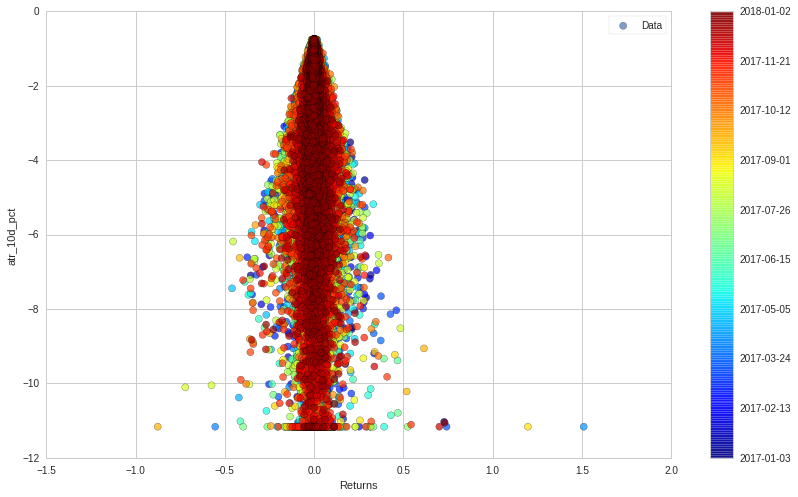

In [43]:
X = results0
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(results0))
sc = plt.scatter(results0['Returns'], results0['atr_10d_pct'], s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Data')
#plt.plot([x.min()[0], x.max()[0]], y_fit, 'black', linestyle='--', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in X[::len(X)//9].index])
plt.xlabel('Returns')
plt.ylabel('atr_10d_pct');

In [44]:
# Compute our stock score
scores = results0['atr_10d_pct_z']
scores_des = scores.describe()
print 'Our Scores\n'
print scores_des
print '\n'

#walk_forward_returns = get_pricing(asset_list, start, end + pd.Timedelta(days=30), fields="price").pct_change()[1:]
walk_forward_returns = results0['Returns']
walk_forward_returns_des = walk_forward_returns.describe()
print 'The Walk Forward Returns\n'
print walk_forward_returns_des
print '\n'

r_s = sts.spearmanr(scores, walk_forward_returns)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

Our Scores

count    4.531910e+05
mean    -5.323493e-17
std      9.999890e-01
min     -1.340727e+01
25%     -4.401312e-01
50%      2.186889e-01
75%      6.816507e-01
max      2.137266e+00
Name: atr_10d_pct_z, dtype: float64


The Walk Forward Returns

count    453191.000000
mean          0.000693
std           0.021665
min          -0.876157
25%          -0.007739
50%           0.000664
75%           0.009197
max           1.509589
Name: Returns, dtype: float64


Correlation Coefficient: 0.0141694472418
p-value: 1.43871456567e-21


In [45]:
x = sm.add_constant(walk_forward_returns, prepend=False)
ols = sm.OLS(scores, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [46]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.000       
Dependent Variable: atr_10d_pct_z    AIC:                1286088.5788
Date:               2019-04-22 01:02 BIC:                1286110.6269
No. Observations:   453191           Log-Likelihood:     -6.4304e+05 
Df Model:           1                F-statistic:        4.767       
Df Residuals:       453189           Prob (F-statistic): 0.0290      
R-squared:          0.000            Scale:              0.99997     
------------------------------------------------------------------------
            Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
------------------------------------------------------------------------
Returns     0.1497      0.0686     2.1833    0.0290     0.0153    0.2841
const      -0.0001      0.0015    -0.0698    0.9443    -0.0030    0.0028
---------------------------------------------------------------------
Omnibus:             189649.257     Durbin-Watson:        1.822      
Prob(Omnibus):       0.000          Jarque-Bera (JB):     1270042.743
Skew:                -1.887         Prob(JB):             0.000      
Kurtosis:            10.281         Condition No.:        46         
=====================================================================

"""

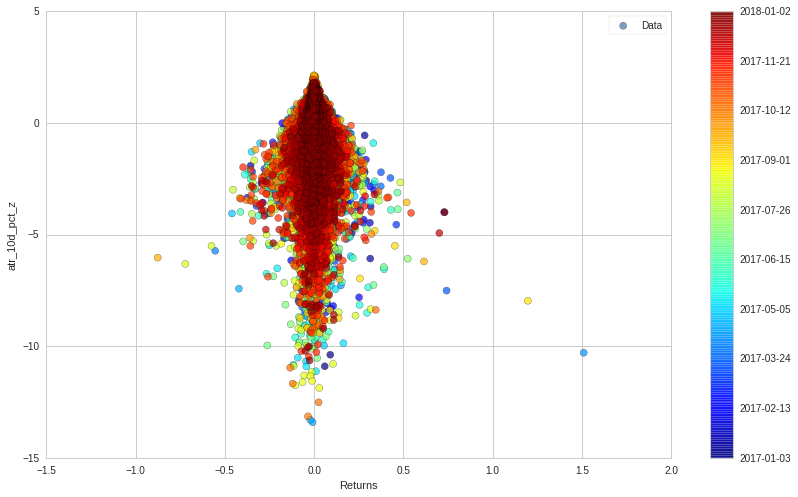

In [47]:
X = results0
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(results0))
sc = plt.scatter(results0['Returns'], results0['atr_10d_pct_z'], s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Data')
#plt.plot([x.min()[0], x.max()[0]], y_fit, 'black', linestyle='--', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in X[::len(X)//9].index])
plt.xlabel('Returns')
plt.ylabel('atr_10d_pct_z');

In [48]:
# Compute our stock score
scores = results0['atr_10d_pct_m']
scores_des = scores.describe()
print 'Our Scores\n'
print scores_des
print '\n'

#walk_forward_returns = get_pricing(asset_list, start, end + pd.Timedelta(days=30), fields="price").pct_change()[1:]
walk_forward_returns = results0['Returns']
walk_forward_returns_des = walk_forward_returns.describe()
print 'The Walk Forward Returns\n'
print walk_forward_returns_des
print '\n'

r_s = sts.spearmanr(scores, walk_forward_returns)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

Our Scores

count    453191.000000
mean         -2.646632
std           0.531899
min          -3.603615
25%          -2.802124
50%          -2.609925
75%          -2.348344
max          -1.588858
Name: atr_10d_pct_m, dtype: float64


The Walk Forward Returns

count    453191.000000
mean          0.000693
std           0.021665
min          -0.876157
25%          -0.007739
50%           0.000664
75%           0.009197
max           1.509589
Name: Returns, dtype: float64


Correlation Coefficient: 0.00278600199034
p-value: 0.0607212172448


In [49]:
x = sm.add_constant(walk_forward_returns, prepend=False)
ols = sm.OLS(scores, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [50]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     -0.000     
Dependent Variable: atr_10d_pct_m    AIC:                713902.4478
Date:               2019-04-22 01:03 BIC:                713924.4960
No. Observations:   453191           Log-Likelihood:     -3.5695e+05
Df Model:           1                F-statistic:        0.002684   
Df Residuals:       453189           Prob (F-statistic): 0.959      
R-squared:          0.000            Scale:              0.28292    
----------------------------------------------------------------------
           Coef.    Std.Err.       t        P>|t|     [0.025    0.975]
----------------------------------------------------------------------
Returns   -0.0019     0.0365      -0.0518   0.9587   -0.0734    0.0696
const     -2.6466     0.0008   -3347.9749   0.0000   -2.6482   -2.6451
--------------------------------------------------------------------
Omnibus:             13321.312      Durbin-Watson:         1.842    
Prob(Omnibus):       0.000          Jarque-Bera (JB):      10168.743
Skew:                -0.278         Prob(JB):              0.000    
Kurtosis:            2.522          Condition No.:         46       
====================================================================

"""

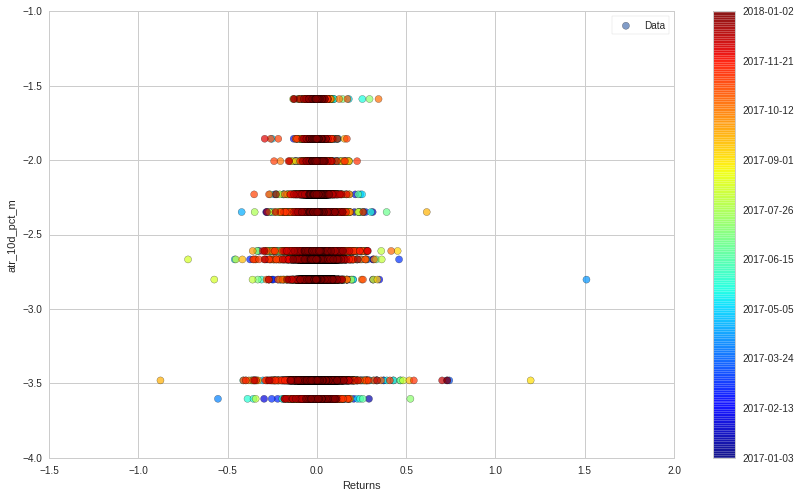

In [51]:
X = results0
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(results0))
sc = plt.scatter(results0['Returns'], results0['atr_10d_pct_m'], s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Data')
#plt.plot([x.min()[0], x.max()[0]], y_fit, 'black', linestyle='--', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in X[::len(X)//9].index])
plt.xlabel('Returns')
plt.ylabel('atr_10d_pct_m');

In [61]:
results.head()

AM   GP_to_A  InfoRatio  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])   57.182050  0.055374   0.534496   
                          Equity(31 [ABAX])   99.798007  0.111836  -0.057970   
                          Equity(41 [ARCB])   29.788708  0.322143   0.747272   
                          Equity(52 [ABM])   229.740330  0.063169   2.371352   
                          Equity(53 [ABMD])  436.383924  0.180346   0.890959   

                                             Piotroski   Returns  SMA_return  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])   1.052283 -0.007624    0.030332   
                          Equity(31 [ABAX])   0.518103 -0.001893    0.017450   
                          Equity(41 [ARCB])   0.518103 -0.015957    0.101464   
                          Equity(52 [ABM])    0.518103  0.001717   -0.002892   
                          Equity(53 [ABMD])  -1.618617 -0.008446   -0.024409   

                                             Sector  atr_10d_pct  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])     311    -1.023109   
                          Equity(31 [ABAX])     206    -2.471075   
                          Equity(41 [ARCB])     310    -3.138251   
                          Equity(52 [ABM])      310    -1.518569   
                          Equity(53 [ABMD])     206    -2.306292   

                                             atr_10d_pct_z  atr_10d_pct_m  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])       1.394389      -2.666887   
                          Equity(31 [ABAX])       0.533083      -3.480016   
                          Equity(41 [ARCB])      -0.729949      -2.348344   
                          Equity(52 [ABM])        0.766791      -2.348344   
                          Equity(53 [ABMD])       0.620148      -3.480016   

                                             atr_10d_pct_win  
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])        -1.023109  
                          Equity(31 [ABAX])        -2.471075  
                          Equity(41 [ARCB])        -3.138251  
                          Equity(52 [ABM])         -1.518569  
                          Equity(53 [ABMD])        -2.306292

In [76]:
start = pd.Timestamp('2014-01-01')
end = pd.Timestamp('2018-01-01')

In [77]:
my_factor = results['atr_10d_pct_z']
sectors = results['Sector']

In [78]:
assets = results.index.levels[1]
num_assets = len(results.index.levels[1])
pricing = get_pricing(assets, start, end, fields="price")
#pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")
print 'Number of Stocks:', num_assets

Number of Stocks: 2515


In [79]:
periods = (1,3,5,10,21)

factor_data = al.utils.get_clean_factor_and_forward_returns(factor=my_factor,
                                                            prices=pricing,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods,
                                                            quantiles = 5)

Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [80]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data,
                                                                                    by_date=True)
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data,
                                                                        by_group=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-29.383231,0.201626,-1.401347,1.122669,349158,20.023892
2,-2.566374,0.645863,-0.264410,0.472384,348534,19.988106
3,-1.590616,0.919248,0.193427,0.377435,348549,19.988966
4,-0.937275,1.188212,0.536843,0.323420,348534,19.988106
5,-0.404505,2.039354,0.921482,0.290262,348932,20.010931


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,0.066,0.065,0.064,0.065,0.067
beta,-0.345,-0.374,-0.380,-0.394,-0.393
Mean Period Wise Return Top Quantile (bps),1.413,1.190,1.106,1.185,1.189
Mean Period Wise Return Bottom Quantile (bps),-1.180,-0.949,-1.059,-1.191,-1.452
Mean Period Wise Spread (bps),2.593,2.219,2.256,2.474,2.730


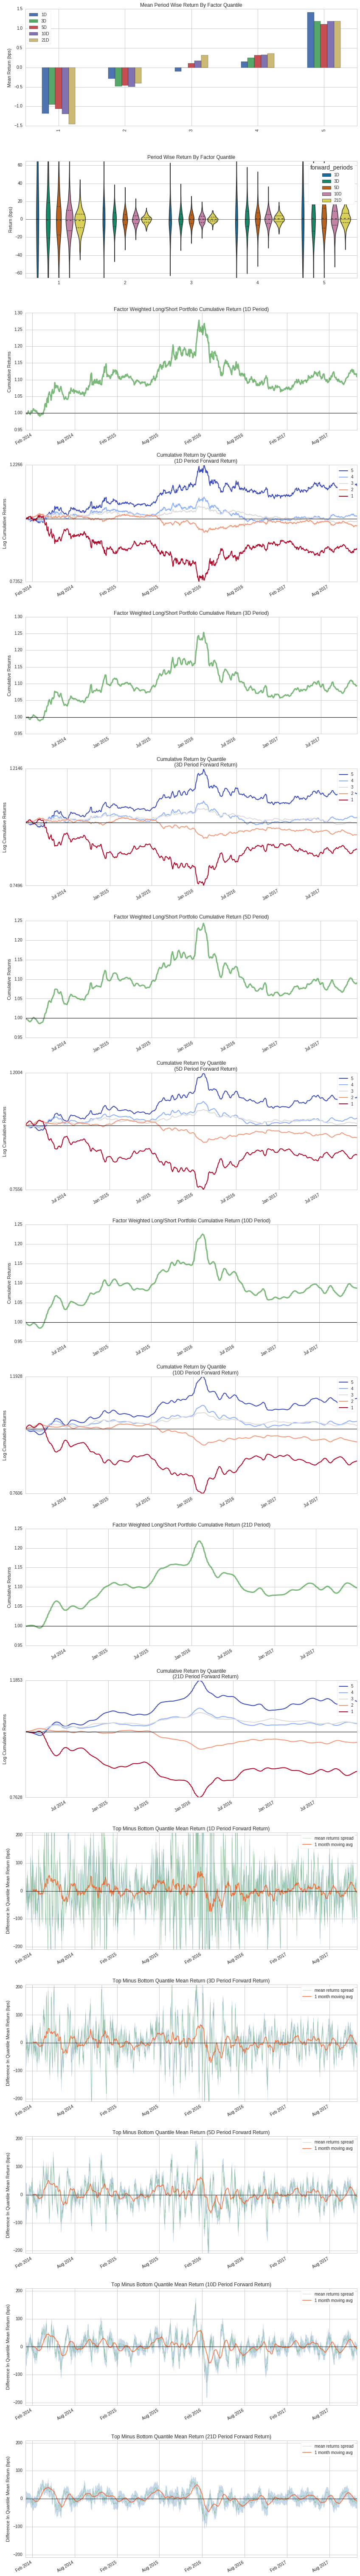

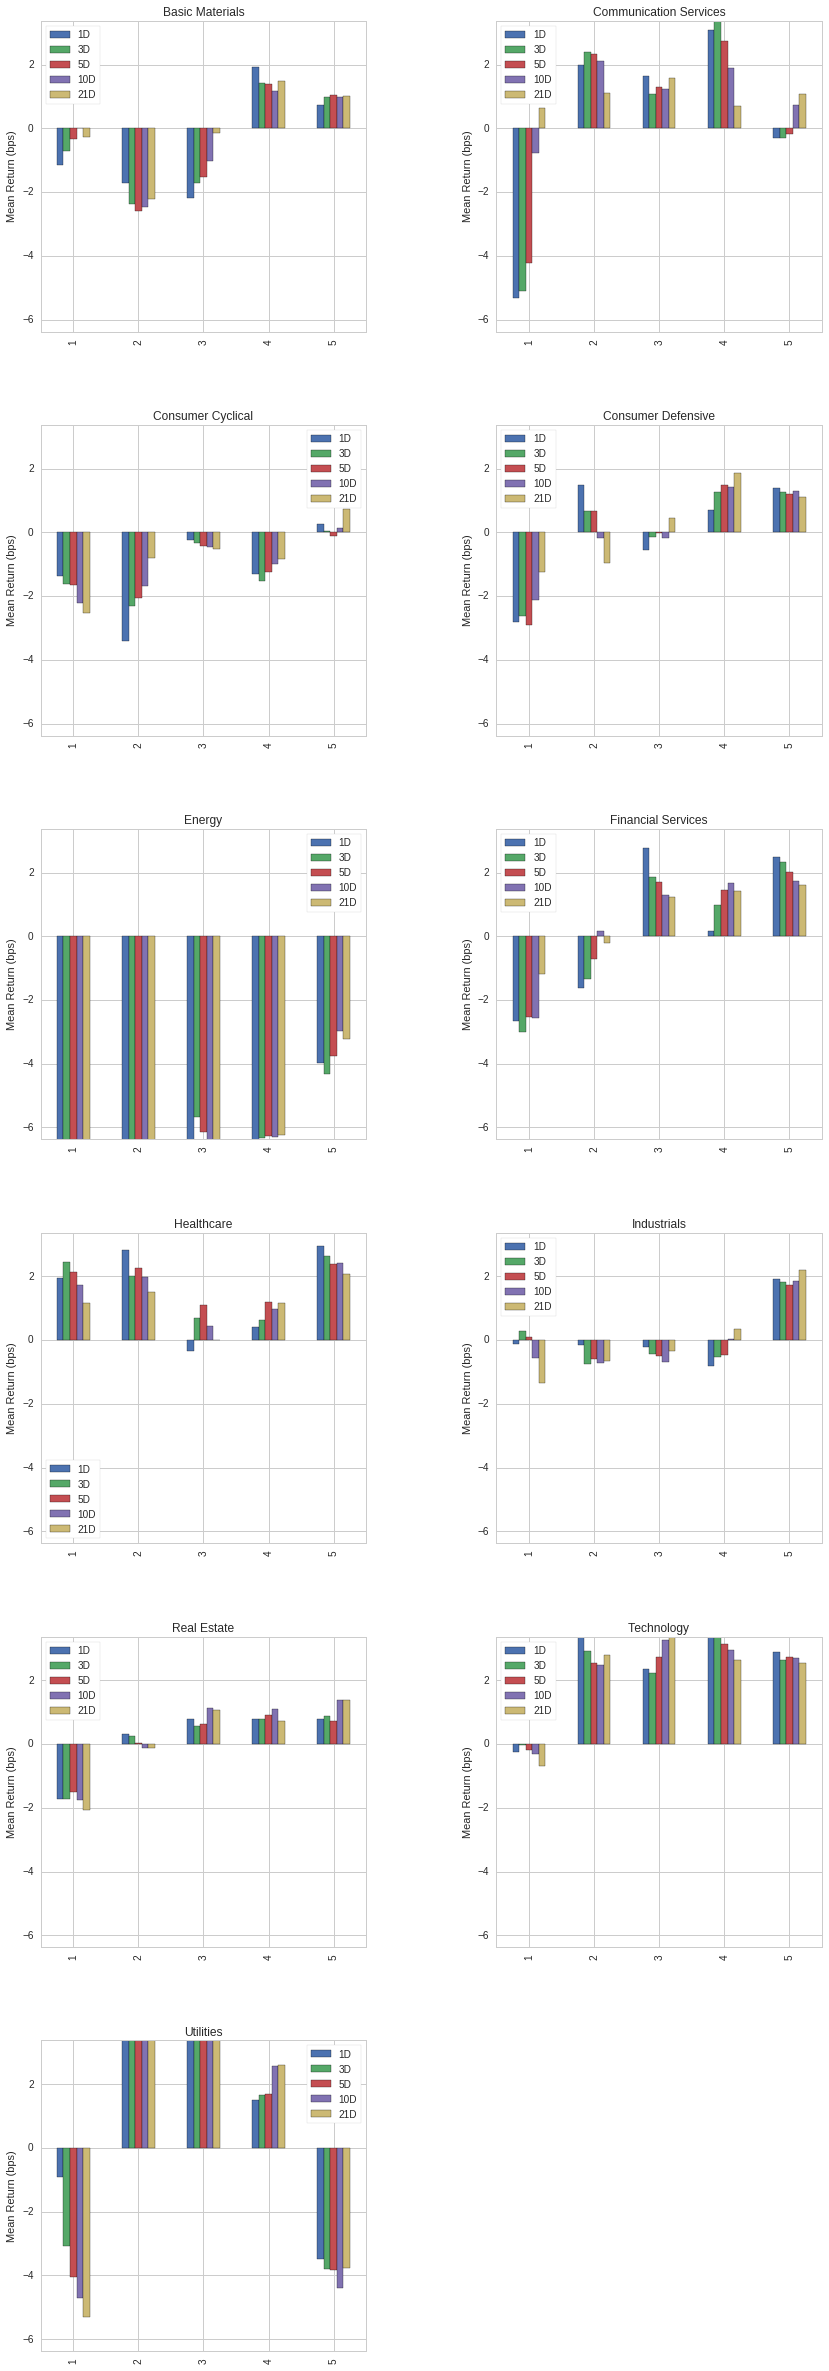

Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.012,0.016,0.017,0.022,0.035
IC Std.,0.164,0.163,0.157,0.151,0.141
Risk-Adjusted IC,0.076,0.098,0.110,0.148,0.246
t-stat(IC),2.371,3.068,3.455,4.642,7.729
p-value(IC),0.018,0.002,0.001,0.000,0.000
IC Skew,0.102,0.002,-0.053,-0.035,-0.050
IC Kurtosis,-0.095,-0.022,-0.232,-0.062,0.033


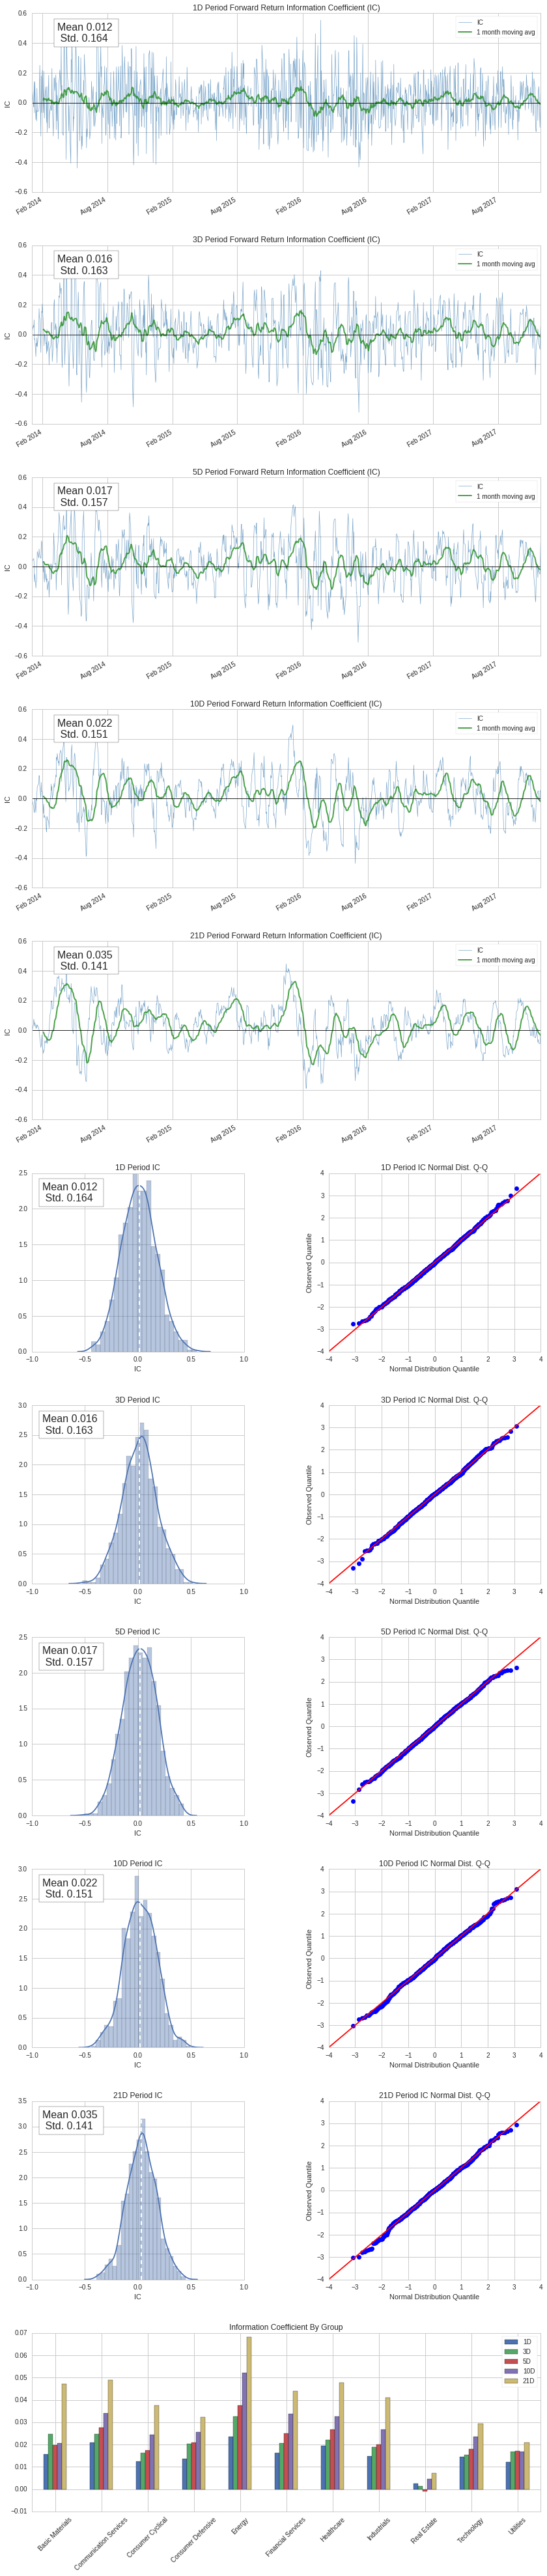

Turnover Analysis


,10D,1D,21D,3D,5D
Quantile 1 Mean Turnover,0.383,0.081,0.413,0.175,0.248
Quantile 2 Mean Turnover,0.628,0.183,0.648,0.364,0.479
Quantile 3 Mean Turnover,0.662,0.216,0.679,0.413,0.528
Quantile 4 Mean Turnover,0.623,0.195,0.642,0.376,0.487
Quantile 5 Mean Turnover,0.358,0.086,0.378,0.175,0.242


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.982,0.935,0.885,0.763,0.742


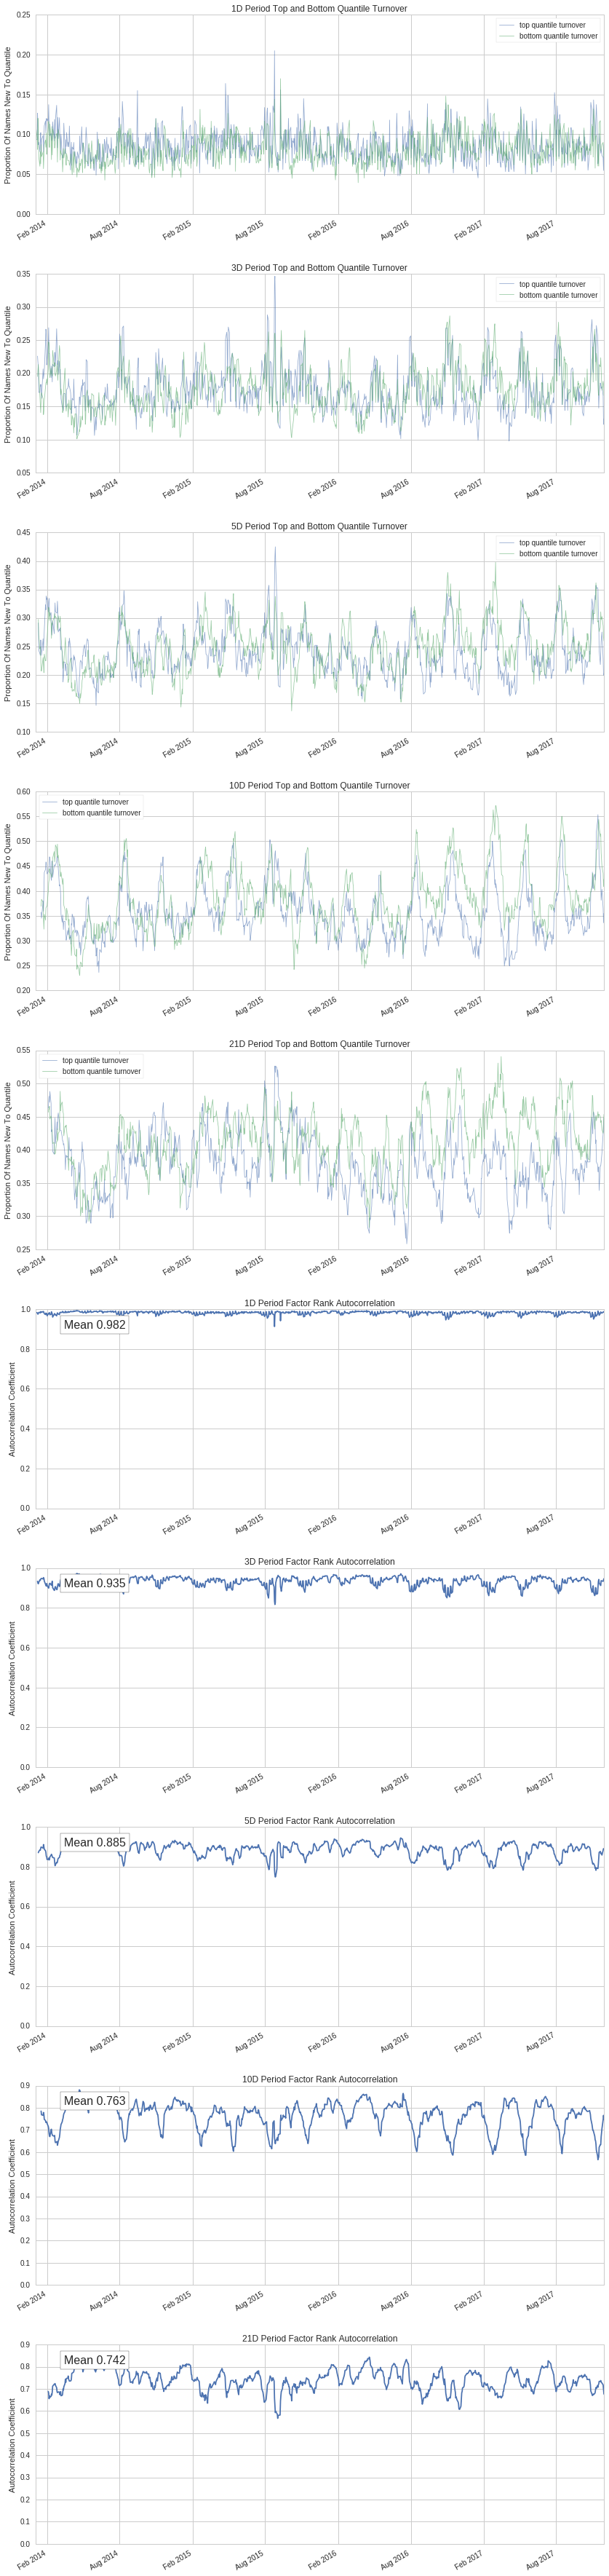

In [81]:
al.tears.create_full_tear_sheet(factor_data, by_group=True);